# Markov Chain Monte-Carlo Experiment

## Imports

In [1]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline

## Data Distribution

In [2]:
mu = 0
sigma = 5
num_population = 100000
population = np.random.normal(mu, sigma, num_population)

Text(0.5, 1.0, 'Data Distribution')

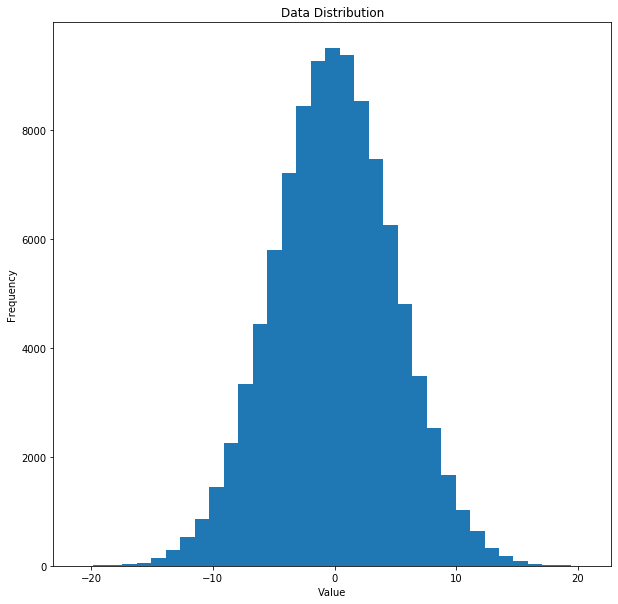

In [3]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist(population,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Data Distribution")

## Sample

In [4]:
num_samples = 1000
observations = population[np.random.randint(0, num_population, num_samples)]

NameError: name 'observation' is not defined

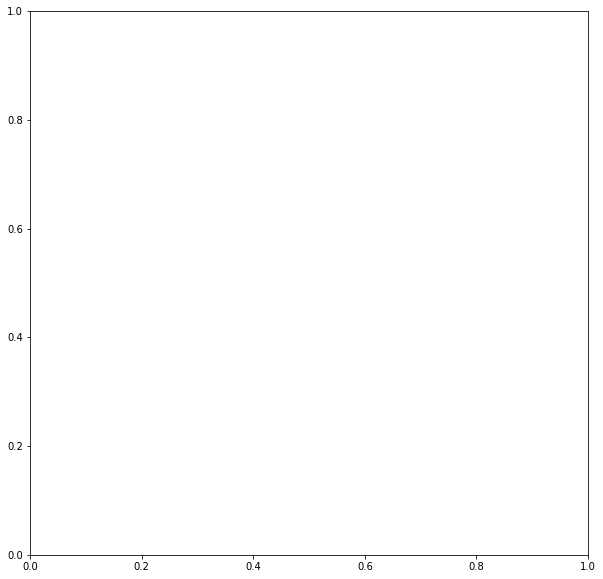

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist(observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Sample Distribution")

## Metropolis Algorithm for estimating $\mu$

In [6]:
def prior(mu):
    return 1

def likelihood(mu, d):
    return np.sum(1/(sigma*np.sqrt(2*np.pi)) * np.exp((-1/2)*np.power(((d-mu)/sigma),2)))


def proposal_dist(mu):
    num_samples = 1
    return np.random.normal(mu,sigma,(num_samples,))[0]


def metropolis(observation, iterations):
    mu_obs=observation.mean()
    init_mu = -1
    state = init_mu
    posterior_samples = []
    rejected = []
    for i in range(iterations):
        candidate = proposal_dist(state)
        candidate_unnormalized_posterior = likelihood(candidate, observation)
        state_unnormalized_posterior = likelihood(state, observation)
        acceptance_ratio = candidate_unnormalized_posterior/state_unnormalized_posterior
        u = np.random.rand()
        if u <= acceptance_ratio:
            state = candidate
            posterior_samples.append(state)
        else:
            rejected.append(candidate)## Metropolis Algorithm for estimating $\mu$
            state = state
    return posterior_samples, rejected

## MCMC Estimate of Posterior $\mathbb{P}[\mu | \mathcal{D}]$ and $\mathbb{E}[\mu]$

In [7]:
posterior_samples, rejected = metropolis(observations, 100000)

Text(0.5, 1.0, 'Sampled Posterior')

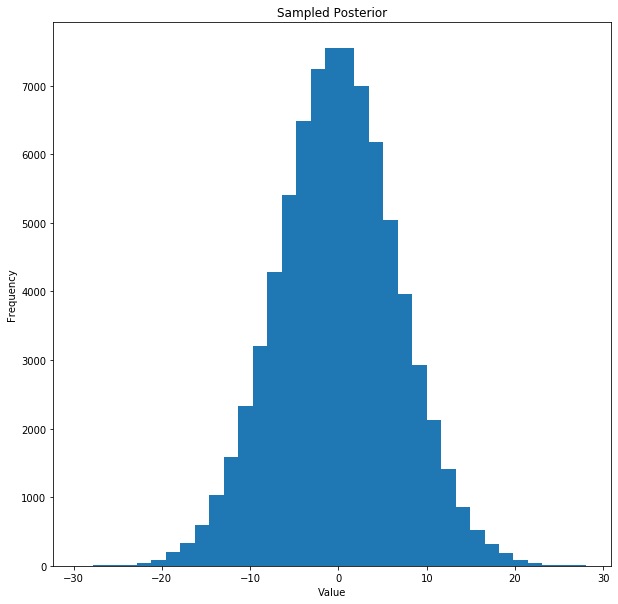

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist(posterior_samples,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Sampled Posterior")

In [9]:
np.mean(posterior_samples)

-0.0897542324779074

## Metropolis-Hastings Algorithm for estimating $\sigma$

In [10]:
mu = 0

In [11]:
def prior(sigma):
    if sigma <= 0:
        return 0
    else:
        return 1

def likelihood(sigma, d):
    #print(mu)
    return np.sum(1/(sigma*np.sqrt(2*np.pi)) * np.exp((-1/2)*np.power(((d-mu)/sigma),2)))


def proposal_dist(sigma):
    num_samples = 1
    return np.random.normal(sigma, 0.5, (num_samples,))[0]

def proposal_dist_cond(d, sigma):
    return np.sum(1/(0.5*np.sqrt(2*np.pi)) * np.exp((-1/2)*np.power(((d-sigma)/0.5),2)))


def metropolis_hastings(observation, iterations):
    mu_obs=observation.mean()
    init_sigma = 3
    state = init_sigma
    posterior_samples = []
    rejected = []
    for i in range(iterations):
        candidate = proposal_dist(state)
        candidate_unnormalized_posterior = likelihood(candidate, observation)
        state_unnormalized_posterior = likelihood(state, observation)
        acceptance_ratio = min(1,((candidate_unnormalized_posterior/state_unnormalized_posterior)
        *((proposal_dist_cond(state, candidate)/proposal_dist_cond(candidate, state)))))
        u = np.random.rand()
        if u <= acceptance_ratio:
            state = candidate
            posterior_samples.append(state)
        else:
            rejected.append(candidate)## Metropolis Algorithm for estimating $\mu$
            state = state
    return posterior_samples, rejected

## MCMC Estimate of Posterior $\mathbb{P}[\sigma | \mathcal{D}]$ and $\mathbb{E}[\sigma]$

In [12]:
posterior_samples, rejected = metropolis_hastings(observations, 100000)

Text(0.5, 1.0, 'Sampled Posterior')

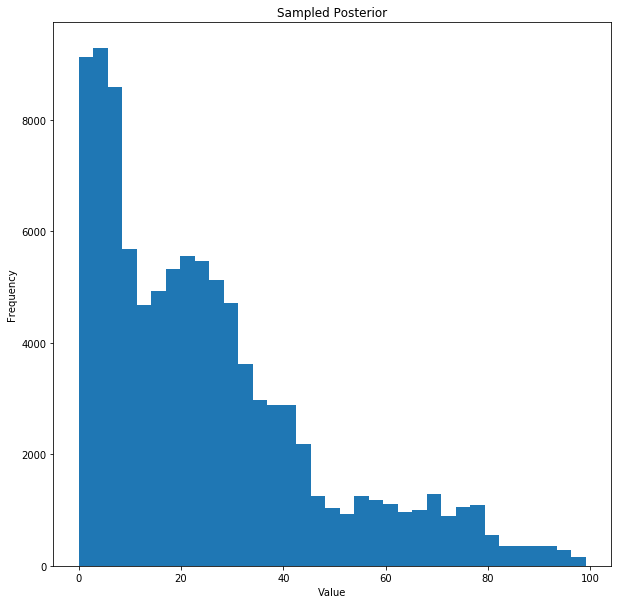

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist(posterior_samples,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Sampled Posterior")

In [14]:
np.mean(posterior_samples)

25.371844348674326

## Data Distribution 2

In [55]:
means = np.array([0,0])
cov = np.array([[1, 0.5], [0.5, 1]])
num_population = 100000
population = np.random.multivariate_normal(means, cov, (num_population,))
joint_mu = np.array([[0],[0]])

In [36]:
population.shape

(100000, 2)

Text(0.5, 1.0, 'Data Distribution')

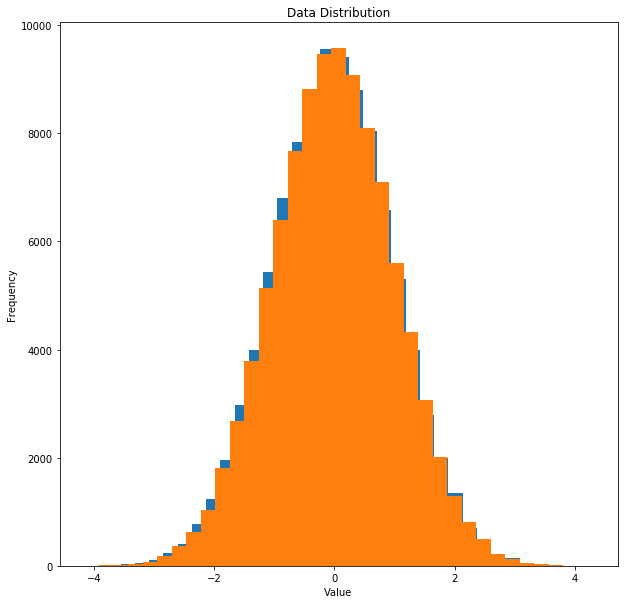

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist(population[:,0],bins=35 ,)
ax.hist(population[:,1],bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Data Distribution")

## Gibbs Sampling for estimating $\mu_1, \mu_2$

In [50]:
L = np.linalg.cholesky(cov)
samples_from_true_distribution =  L @ np.random.randn(2, 10000) + joint_mu

In [70]:
def get_conditional_dist(joint_mu, joint_cov, var_index):
    '''Returns the conditional distribution given the joint distribution and which variable
    the conditional probability should use.
    Right now this only works for 2-variable joint distributions.
    
      joint_mu: joint distribution's mu
      joint_cov: joint distribution's covariance
      var_index: index of the variable in the joint distribution. Everything else will be 
        conditioned on. For example, if the joint distribution p(a, b, c) has mu [mu_a, mu_b, mu_c],
        to get p(c | a, b), use var_index = 2.
      
    returns:
      a function that can sample from the univariate conditional distribution
    '''
    assert joint_mu.shape[0] == 2, 'Sorry, this function only works for 2-dimensional joint distributions right now'
    a = joint_mu[var_index]
    b = joint_mu[~var_index]
    
    A = joint_cov[var_index, var_index]
    B = joint_cov[~var_index, ~var_index]
    C = joint_cov[var_index, ~var_index]
    
    # we're dealing with one dimension so
    B_inv = 1/B
    
    # Return a function that can sample given a value of g
    def dist(g):
        # a + C*B^{-1}(g - b)
        mu = a + C * B_inv * (g - b)
        # A - C * B^{-1} * C^T
        cov = A - B_inv * C * C
        return np.sqrt(cov) * np.random.randn(1) + mu
    
    return dist

In [71]:
# Set up the conditional probability distribution for each dimension
# For example, I can sample p(a | b) using sample_for_dim[0].

univariate_conditionals = [
    get_conditional_dist(joint_mu, joint_cov, d)
    for d in range(D)
]

In [73]:
def gibbs_sample(univariate_conditionals, sample_count):
    '''Does Gibbs sampling given the distribution's univariate conditionals.
    
    Returns a D x N matrix
    '''
    D = len(univariate_conditionals)
    assert D == 2, "Sorry, this only supports 2 dimensions right now"
    
    # initializes an empty matrix for the samples
    samples = np.zeros((D, sample_count))

    # initialize the first sample to some arbitrary value
    samples[:, 0] = [3, -3]
    
    for i in range(1, sample_count):
        # first set this sample equal to the previous sample
        samples[:, i] = samples[:, i - 1]
        
        # now update the dimension whose turn it is using the conditional distribution
        # pass in all dimension from the previous sample except this dimension
        d = i % D
        samples[d, i] = univariate_conditionals[d](samples[~d, i - 1])
                 
    return samples

In [79]:
samples = gibbs_sample(univariate_conditionals, sample_count=1000)

In [80]:
samples.shape

(2, 1000)

Text(0.5, 1.0, 'Data Distribution')

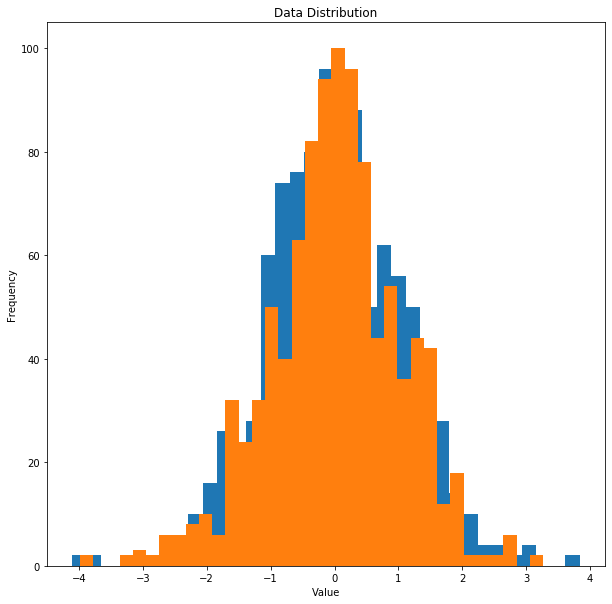

In [81]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist(samples[0],bins=35 ,)
ax.hist(samples[1],bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Data Distribution")